# VAEGAN: Hybrid VAE-GAN Model

This notebook implements a hybrid VAEGAN model that combines:
- VAE as generator with 4-layer encoder/decoder
- WGAN critic for adversarial training
- Modified VAE loss with critic feedback


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
import logging
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(name)s | %(levelname)s | %(message)s'
)
logger = logging.getLogger('VAEGAN')
logger.info(f"Device: {device}")


VAEGAN | INFO | Device: cuda


In [4]:
class DataLoaderModule:
    """Simple dataloader for MNIST and CIFAR10"""
    
    def __init__(self, batch_size=64):
        self.batch_size = batch_size
        self.logger = logging.getLogger('VAEGAN.DataLoader')
        
    def load_mnist(self):
        self.logger.info("Loading MNIST dataset")
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # [-1, 1] range
        ])
        
        dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.logger.info(f"MNIST loaded: {len(dataloader)} batches")
        return dataloader, 1, [64, 64]
    
    def load_cifar10(self):
        self.logger.info("Loading CIFAR10 dataset")
        transform = transforms.Compose([
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # [-1, 1] range
        ])
        
        dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        self.logger.info(f"CIFAR10 loaded: {len(dataloader)} batches")
        return dataloader, 3, [64, 64]


In [5]:
class VAEGenerator(nn.Module):
    """Dynamic VAE with 4-layer encoder and decoder based on latent_dim"""
    
    def __init__(self, input_channels=1, latent_dim=128, img_size=64):
        super().__init__()
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.logger = logging.getLogger('VAEGAN.VAEGenerator')
        
        # Dynamic channel sizes based on latent_dim
        base_dim = latent_dim // 2  # latent_dim/2
        dim2 = latent_dim           # latent_dim
        dim3 = latent_dim * 2       # latent_dim*2  
        dim4 = latent_dim * 4       # latent_dim*4
        
        # 4-layer encoder - progressively increase channels
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, base_dim, 4, 2, 1),  # 64x64 -> 32x32
            nn.BatchNorm2d(base_dim),
            nn.ReLU(),
            
            nn.Conv2d(base_dim, dim2, 4, 2, 1),  # 32x32 -> 16x16
            nn.BatchNorm2d(dim2),
            nn.ReLU(),
            
            nn.Conv2d(dim2, dim3, 4, 2, 1),  # 16x16 -> 8x8
            nn.BatchNorm2d(dim3),
            nn.ReLU(),
            
            nn.Conv2d(dim3, dim4, 4, 2, 1),  # 8x8 -> 4x4
            nn.BatchNorm2d(dim4),
            nn.ReLU(),
        )
        
        # Latent projection
        self.fc_mu = nn.Linear(dim4 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(dim4 * 4 * 4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, dim4 * 4 * 4)
        
        # 4-layer decoder - progressively decrease channels
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(dim4, dim3, 4, 2, 1),  # 4x4 -> 8x8
            nn.BatchNorm2d(dim3),
            nn.ReLU(),
            
            nn.ConvTranspose2d(dim3, dim2, 4, 2, 1),  # 8x8 -> 16x16
            nn.BatchNorm2d(dim2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(dim2, base_dim, 4, 2, 1),  # 16x16 -> 32x32
            nn.BatchNorm2d(base_dim),
            nn.ReLU(),
            
            nn.ConvTranspose2d(base_dim, input_channels, 4, 2, 1),  # 32x32 -> 64x64
            nn.Tanh()
        )
        
        self.logger.info(f"Dynamic VAE Generator: channels={input_channels}, latent_dim={latent_dim}, dims=[{base_dim}, {dim2}, {dim3}, {dim4}]")
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.fc_decode(z)
        h = h.view(h.size(0), self.latent_dim * 4, 4, 4)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [6]:
class Critic(nn.Module):
    """Dynamic WGAN-GP Critic with gradient penalty"""
    
    def __init__(self, input_channels=1, latent_dim=128):
        super().__init__()
        self.logger = logging.getLogger('VAEGAN.Critic')
        
        # Dynamic channel sizes based on latent_dim
        base_dim = latent_dim // 2  # latent_dim/2
        dim2 = latent_dim           # latent_dim
        dim3 = latent_dim * 2       # latent_dim*2
        dim4 = latent_dim * 4       # latent_dim*4
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_channels, base_dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(base_dim, dim2, 4, 2, 1),
            nn.BatchNorm2d(dim2),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(dim2, dim3, 4, 2, 1),
            nn.BatchNorm2d(dim3),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(dim3, dim4, 4, 2, 1),
            nn.BatchNorm2d(dim4),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Linear(dim4 * 4 * 4, 1)
        self.logger.info(f"Dynamic Critic: channels={input_channels}, latent_dim={latent_dim}, dims=[{base_dim}, {dim2}, {dim3}, {dim4}]")
    
    def forward(self, x):
        h = self.conv_layers(x)
        h = h.view(h.size(0), -1)
        return self.fc(h).squeeze()
    
    def gradient_penalty(self, real_images, fake_images, device):
        """Calculate gradient penalty for WGAN-GP"""
        batch_size = real_images.size(0)
        
        # Random interpolation weight
        alpha = torch.rand(batch_size, 1, 1, 1, device=device)
        
        # Interpolated images
        interpolated = alpha * real_images + (1 - alpha) * fake_images
        interpolated.requires_grad_(True)
        
        # Critic scores for interpolated images
        scores = self.forward(interpolated)
        
        # Calculate gradients
        gradients = torch.autograd.grad(
            outputs=scores,
            inputs=interpolated,
            grad_outputs=torch.ones_like(scores),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        
        # Gradient penalty
        gradients = gradients.view(batch_size, -1)
        gradient_norm = gradients.norm(2, dim=1)
        penalty = torch.mean((gradient_norm - 1) ** 2)
        
        return penalty


In [7]:
class VAEGAN(nn.Module):
    """Dynamic Hybrid VAEGAN model with VAE generator and WGAN-GP critic"""
    
    def __init__(self, input_channels=1, latent_dim=128, img_size=64, lambda_gp=10):
        super().__init__()
        self.logger = logging.getLogger('VAEGAN.Model')
        self.lambda_gp = lambda_gp
        
        # Dynamic models based on latent_dim
        self.generator = VAEGenerator(input_channels, latent_dim, img_size).to(device)
        self.critic = Critic(input_channels, latent_dim).to(device)
        
        self.logger.info(f"Dynamic VAEGAN initialized: latent_dim={latent_dim}, lambda_gp={lambda_gp}")
    
    def vae_loss(self, x, recon, mu, logvar, critic_score):
        """Modified VAE loss with critic feedback"""
        # Standard VAE losses
        recon_loss = F.mse_loss(recon, x, reduction='mean')
        kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Adversarial loss - generator wants high critic scores
        adv_loss = -torch.mean(critic_score)
        
        return recon_loss, kl_loss, adv_loss
    
    def critic_loss(self, real_score, fake_score, gp):
        """WGAN-GP critic loss with gradient penalty"""
        return torch.mean(fake_score) - torch.mean(real_score) + self.lambda_gp * gp
    
    def train_step(self, real_images, g_optimizer, c_optimizer, 
                   recon_weight=1.0, kl_weight=0.1, adv_weight=0.1, critic_iters=5):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)
        
        # Train Critic multiple times with gradient penalty
        for _ in range(critic_iters):
            c_optimizer.zero_grad()
            
            # Real images
            real_score = self.critic(real_images)
            
            # Fake images from VAE
            with torch.no_grad():
                fake_images, _, _ = self.generator(real_images)
            fake_score = self.critic(fake_images)
            
            # Gradient penalty
            gp = self.critic.gradient_penalty(real_images, fake_images, device)
            
            c_loss = self.critic_loss(real_score, fake_score, gp)
            c_loss.backward()
            c_optimizer.step()
        
        # Train Generator (VAE)
        g_optimizer.zero_grad()
        
        # VAE forward pass
        recon, mu, logvar = self.generator(real_images)
        
        # Get critic score for reconstructed images
        critic_score = self.critic(recon)
        
        # Calculate losses
        recon_loss, kl_loss, adv_loss = self.vae_loss(real_images, recon, mu, logvar, critic_score)
        
        # Combined generator loss
        g_loss = recon_weight * recon_loss + kl_weight * kl_loss + adv_weight * adv_loss
        g_loss.backward()
        g_optimizer.step()
        
        return {
            'g_loss': g_loss.item(),
            'c_loss': c_loss.item(),
            'recon_loss': recon_loss.item(),
            'kl_loss': kl_loss.item(),
            'adv_loss': adv_loss.item(),
            'gp': gp.item()
        }


In [8]:
class Trainer:
    """Training loop with visualization"""
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.history = defaultdict(list)
        self.logger = logging.getLogger('VAEGAN.Trainer')
        
    def train(self, dataloader, epochs=10, lr_g=1e-3, lr_c=5e-5, critic_iters=5):
        self.logger.info(f"Starting training for {epochs} epochs")
        
        # Use Adam for both optimizers with WGAN-GP
        g_optimizer = optim.Adam(self.model.generator.parameters(), lr=lr_g, betas=(0.0, 0.9))
        c_optimizer = optim.Adam(self.model.critic.parameters(), lr=lr_c, betas=(0.0, 0.9))
        
        for epoch in range(epochs):
            epoch_metrics = defaultdict(list)
            
            for batch_idx, (real_images, _) in enumerate(dataloader):
                metrics = self.model.train_step(real_images, g_optimizer, c_optimizer, critic_iters=1)
                
                for key, value in metrics.items():
                    epoch_metrics[key].append(value)
                    self.history[key].append(value)
                
                if batch_idx % 100 == 0:
                    self.logger.info(
                        f"Epoch {epoch} Batch {batch_idx}: "
                        f"G_loss={metrics['g_loss']:.4f} "
                        f"C_loss={metrics['c_loss']:.4f} "
                        f"Recon={metrics['recon_loss']:.4f} "
                        f"GP={metrics['gp']:.4f}"
                    )
            
            # Epoch summary
            avg_metrics = {k: np.mean(v) for k, v in epoch_metrics.items()}
            self.logger.info(
                f"Epoch {epoch} complete: "
                f"G_loss={avg_metrics['g_loss']:.4f} "
                f"C_loss={avg_metrics['c_loss']:.4f} "
                f"Recon={avg_metrics['recon_loss']:.4f} "
                f"KL={avg_metrics['kl_loss']:.4f} "
                f"Adv={avg_metrics['adv_loss']:.4f} "
                f"GP={avg_metrics['gp']:.4f}"
            )
            
            # Visualize reconstruction after each epoch
            self.plot_reconstruction(dataloader, epoch)
    
    def plot_reconstruction(self, dataloader, epoch):
        """Plot original vs reconstructed images"""
        self.model.eval()
        
        with torch.no_grad():
            # Get sample batch
            for real_images, _ in dataloader:
                break
            
            real_images = real_images[:8].to(self.device)
            recon_images, _, _ = self.model.generator(real_images)
            
            # Plot comparison
            fig, axes = plt.subplots(2, 8, figsize=(16, 4))
            
            for i in range(8):
                # Original
                img = real_images[i].cpu()
                if img.shape[0] == 1:
                    axes[0, i].imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
                else:
                    img = (img + 1) / 2  # Denormalize
                    axes[0, i].imshow(img.permute(1, 2, 0))
                axes[0, i].axis('off')
                
                # Reconstructed
                img = recon_images[i].cpu()
                if img.shape[0] == 1:
                    axes[1, i].imshow(img.squeeze(), cmap='gray', vmin=-1, vmax=1)
                else:
                    img = (img + 1) / 2  # Denormalize
                    axes[1, i].imshow(img.permute(1, 2, 0))
                axes[1, i].axis('off')
            
            axes[0, 0].set_ylabel('Original', fontsize=12)
            axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
            plt.suptitle(f'Reconstruction Quality - Epoch {epoch}', fontsize=14)
            plt.tight_layout()

            #save the figure to a folder 
            plt.savefig(f'reconstruction_epoch_{epoch}.png')
            plt.show()
        
        self.model.train()
    
    def plot_history(self):
        """Plot training loss history"""
        fig, axes = plt.subplots(2, 3, figsize=(15, 8))
        
        metrics = ['g_loss', 'c_loss', 'recon_loss', 'kl_loss', 'adv_loss', 'gp']
        
        for i, metric in enumerate(metrics):
            if metric in self.history:
                row, col = i // 3, i % 3
                axes[row, col].plot(self.history[metric])
                axes[row, col].set_title(metric.replace('_', ' ').title())
                axes[row, col].grid(True)
        
        # All subplots should be filled now with 6 metrics
        
        plt.suptitle('Training History', fontsize=16)
        plt.tight_layout()
        plt.show()


VAEGAN | INFO | Starting VAEGAN training
VAEGAN | INFO | ==================================================
VAEGAN.DataLoader | INFO | Loading CIFAR10 dataset


Files already downloaded and verified


VAEGAN.DataLoader | INFO | CIFAR10 loaded: 500 batches
VAEGAN.VAEGenerator | INFO | Dynamic VAE Generator: channels=3, latent_dim=128, dims=[64, 128, 256, 512]
VAEGAN.Critic | INFO | Dynamic Critic: channels=3, latent_dim=128, dims=[64, 128, 256, 512]
VAEGAN.Model | INFO | Dynamic VAEGAN initialized: latent_dim=128, lambda_gp=10
VAEGAN | INFO | Training on CIFAR10
VAEGAN.Trainer | INFO | Starting training for 10 epochs
/home/sbeeredd/miniconda3/envs/env/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
VAEGAN.Trainer | INFO | Epoch 0 Batch 0: G_loss=1.2076 C_loss=1.3826 Recon=0.5921 GP=0.1351
VAEGAN.Trainer | INFO | Epoch 0 Batch 100: G_loss=

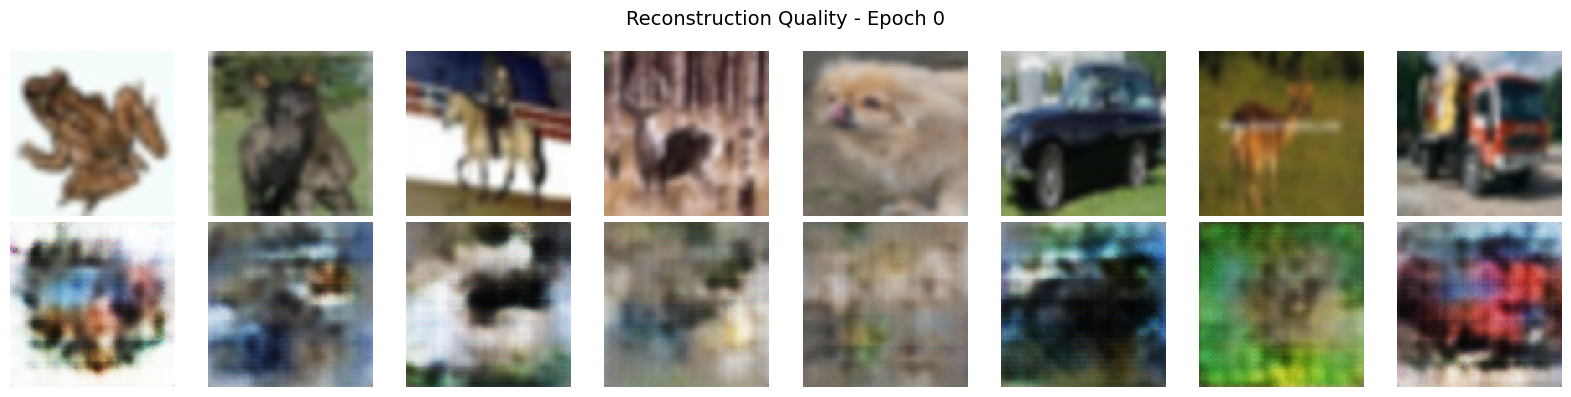

VAEGAN.Trainer | INFO | Epoch 1 Batch 0: G_loss=0.1586 C_loss=-0.2599 Recon=0.1540 GP=0.0989
VAEGAN.Trainer | INFO | Epoch 1 Batch 100: G_loss=0.0899 C_loss=-0.4752 Recon=0.1813 GP=0.0062
VAEGAN.Trainer | INFO | Epoch 1 Batch 200: G_loss=0.0103 C_loss=-0.9596 Recon=0.1666 GP=0.0037
VAEGAN.Trainer | INFO | Epoch 1 Batch 300: G_loss=-0.0673 C_loss=-0.6870 Recon=0.1460 GP=0.0050
VAEGAN.Trainer | INFO | Epoch 1 Batch 400: G_loss=-0.2698 C_loss=-0.5596 Recon=0.1469 GP=0.0121
VAEGAN.Trainer | INFO | Epoch 1 complete: G_loss=-0.0852 C_loss=-0.3383 Recon=0.1531 KL=0.2781 Adv=-2.6608 GP=0.0187


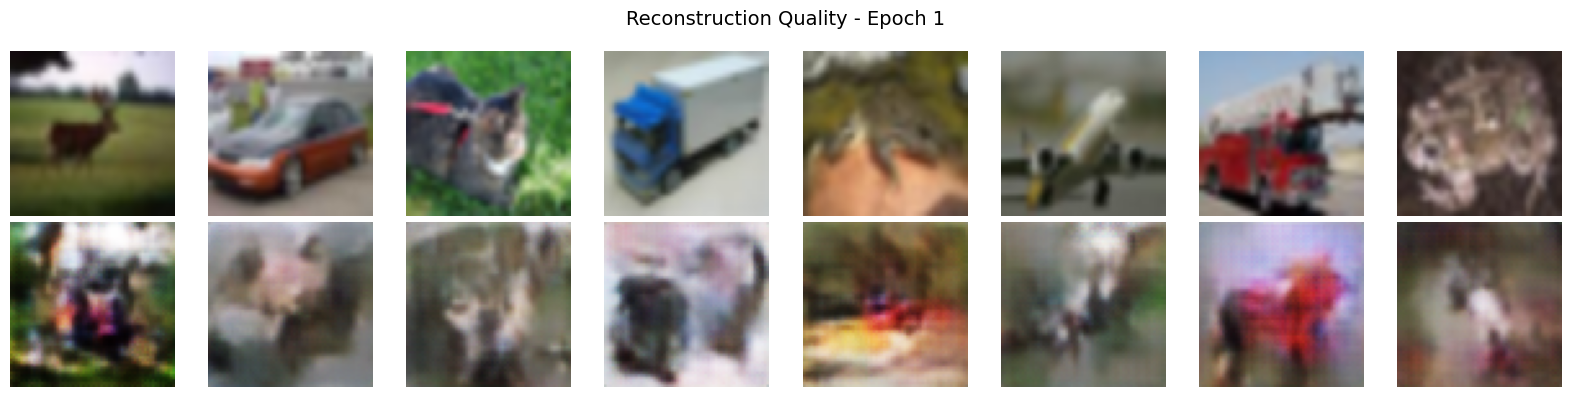

VAEGAN.Trainer | INFO | Epoch 2 Batch 0: G_loss=-0.3112 C_loss=-0.3541 Recon=0.1245 GP=0.0146
VAEGAN.Trainer | INFO | Epoch 2 Batch 100: G_loss=-0.2237 C_loss=-0.2421 Recon=0.1418 GP=0.0164
VAEGAN.Trainer | INFO | Epoch 2 Batch 200: G_loss=-0.1235 C_loss=-0.3811 Recon=0.1283 GP=0.0054
VAEGAN.Trainer | INFO | Epoch 2 Batch 300: G_loss=-0.1849 C_loss=-0.5022 Recon=0.1311 GP=0.0058
VAEGAN.Trainer | INFO | Epoch 2 Batch 400: G_loss=-0.1608 C_loss=-0.4833 Recon=0.1209 GP=0.0071
VAEGAN.Trainer | INFO | Epoch 2 complete: G_loss=-0.1784 C_loss=-0.4583 Recon=0.1266 KL=0.3034 Adv=-3.3537 GP=0.0113


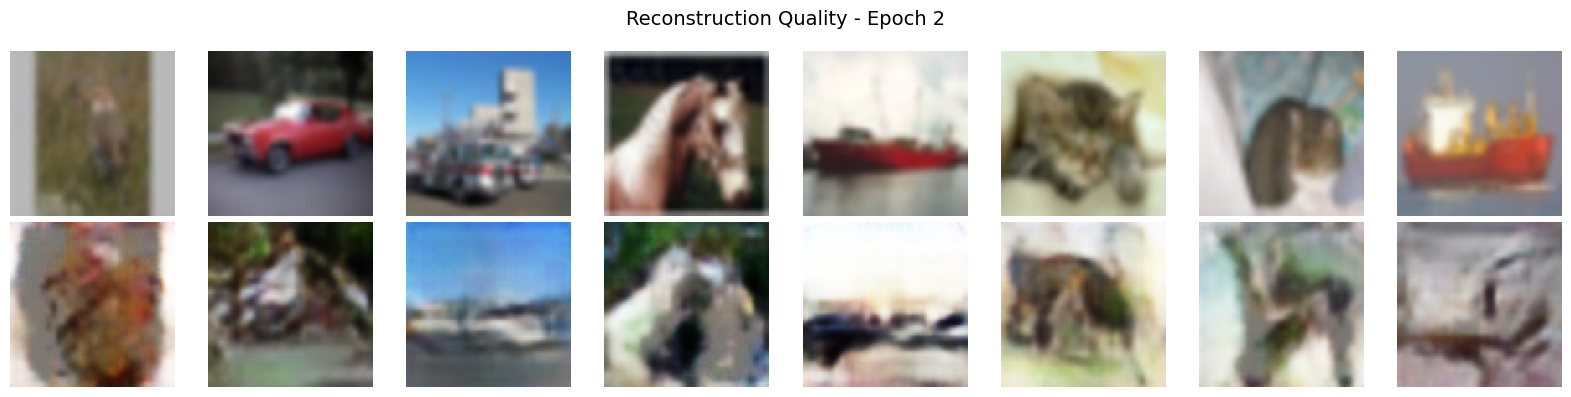

VAEGAN.Trainer | INFO | Epoch 3 Batch 0: G_loss=-0.0307 C_loss=-0.7760 Recon=0.0990 GP=0.0071
VAEGAN.Trainer | INFO | Epoch 3 Batch 100: G_loss=-0.1772 C_loss=-0.2727 Recon=0.1179 GP=0.0200
VAEGAN.Trainer | INFO | Epoch 3 Batch 200: G_loss=-0.0697 C_loss=-0.5388 Recon=0.1331 GP=0.0091
VAEGAN.Trainer | INFO | Epoch 3 Batch 300: G_loss=-0.0182 C_loss=-0.4813 Recon=0.1169 GP=0.0069
VAEGAN.Trainer | INFO | Epoch 3 Batch 400: G_loss=-0.0501 C_loss=-0.3342 Recon=0.1180 GP=0.0160
VAEGAN.Trainer | INFO | Epoch 3 complete: G_loss=-0.0539 C_loss=-0.3845 Recon=0.1130 KL=0.3208 Adv=-1.9905 GP=0.0092


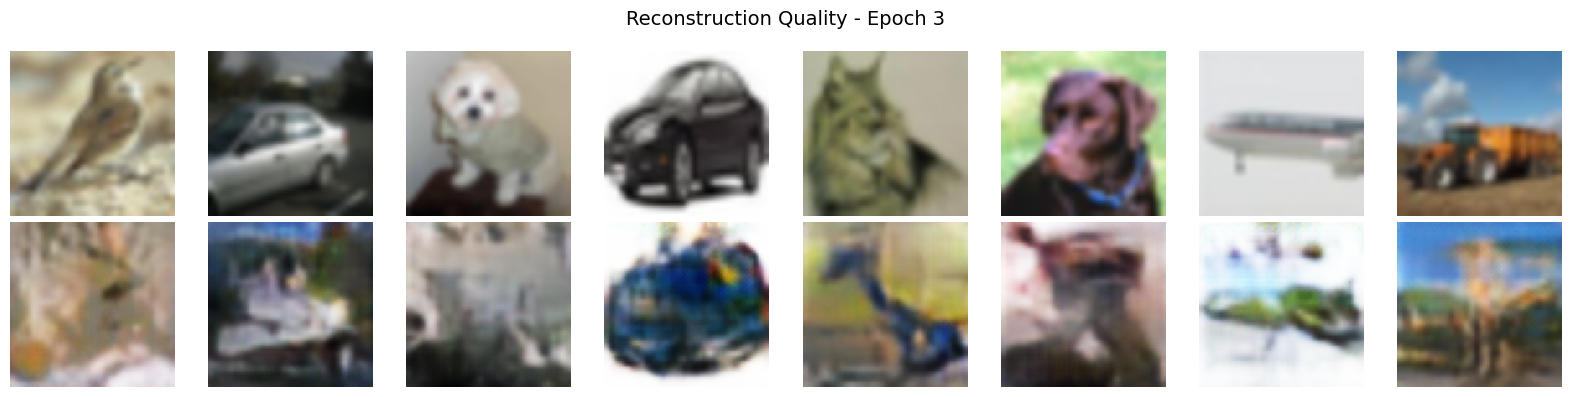

VAEGAN.Trainer | INFO | Epoch 4 Batch 0: G_loss=0.0482 C_loss=-0.3280 Recon=0.1093 GP=0.0110
VAEGAN.Trainer | INFO | Epoch 4 Batch 100: G_loss=0.0642 C_loss=-0.6756 Recon=0.1114 GP=0.0034
VAEGAN.Trainer | INFO | Epoch 4 Batch 200: G_loss=0.0827 C_loss=-0.1731 Recon=0.1061 GP=0.0068
VAEGAN.Trainer | INFO | Epoch 4 Batch 300: G_loss=0.0283 C_loss=-0.5634 Recon=0.1067 GP=0.0048
VAEGAN.Trainer | INFO | Epoch 4 Batch 400: G_loss=0.1680 C_loss=-0.4456 Recon=0.0962 GP=0.0165
VAEGAN.Trainer | INFO | Epoch 4 complete: G_loss=0.0872 C_loss=-0.3942 Recon=0.1042 KL=0.3366 Adv=-0.5067 GP=0.0079


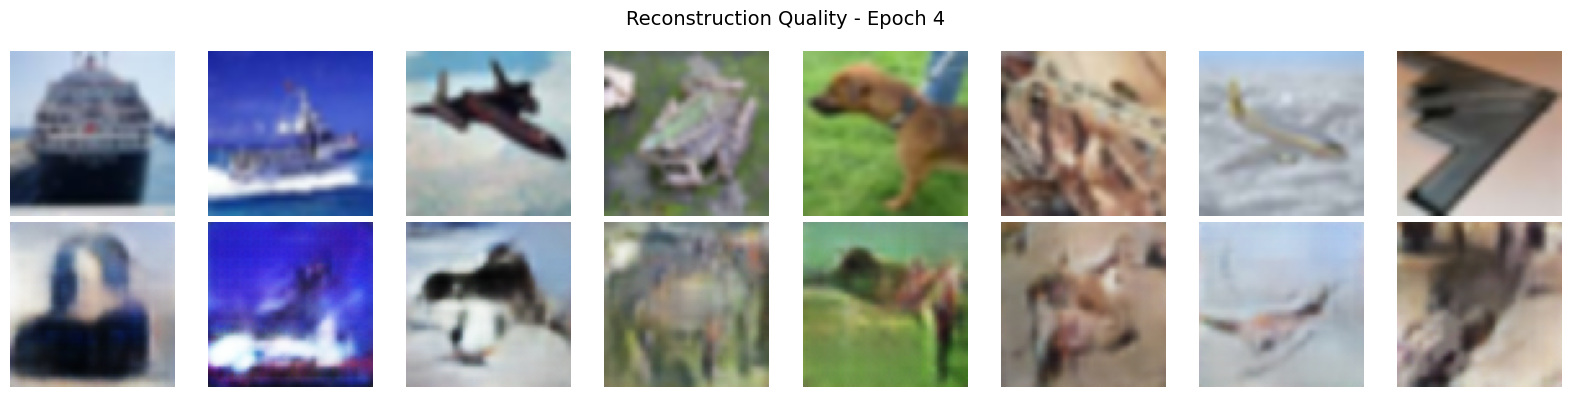

VAEGAN.Trainer | INFO | Epoch 5 Batch 0: G_loss=0.1629 C_loss=-0.3432 Recon=0.1069 GP=0.0064
VAEGAN.Trainer | INFO | Epoch 5 Batch 100: G_loss=0.2360 C_loss=-0.3304 Recon=0.1052 GP=0.0048
VAEGAN.Trainer | INFO | Epoch 5 Batch 200: G_loss=0.4022 C_loss=-0.5898 Recon=0.0998 GP=0.0044
VAEGAN.Trainer | INFO | Epoch 5 Batch 300: G_loss=0.3471 C_loss=-0.5025 Recon=0.0891 GP=0.0050
VAEGAN.Trainer | INFO | Epoch 5 Batch 400: G_loss=0.4072 C_loss=-0.5490 Recon=0.0928 GP=0.0174
VAEGAN.Trainer | INFO | Epoch 5 complete: G_loss=0.3306 C_loss=-0.4564 Recon=0.0987 KL=0.3444 Adv=1.9745 GP=0.0066


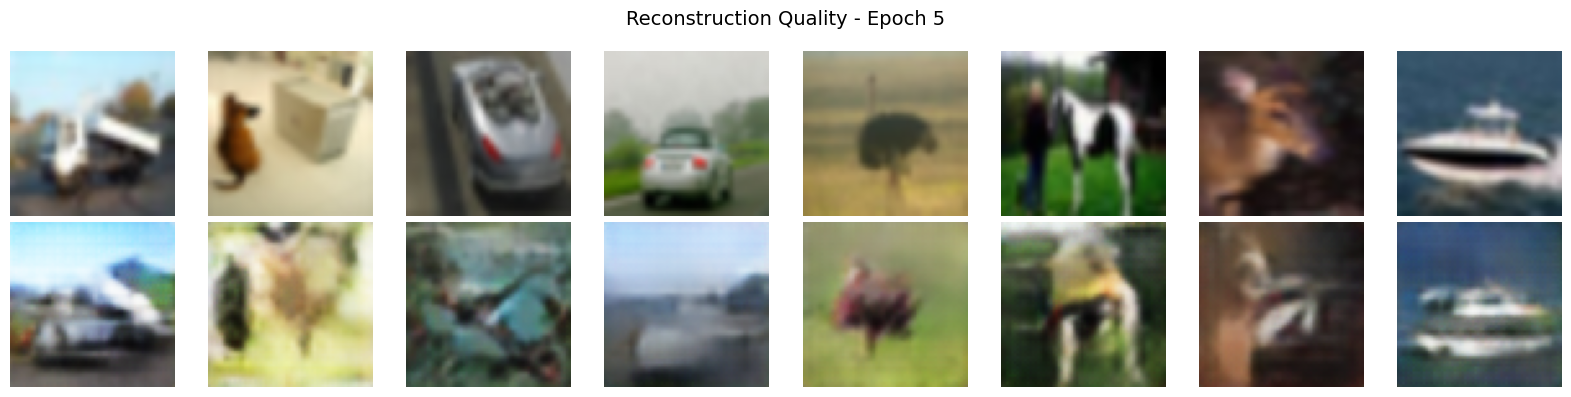

VAEGAN.Trainer | INFO | Epoch 6 Batch 0: G_loss=0.4455 C_loss=-0.6553 Recon=0.0939 GP=0.0039


In [ ]:
if __name__ == "__main__":
    # Setup
    logger.info("Starting VAEGAN training")
    logger.info("=" * 50)
    
    # Create dataloader
    data_loader = DataLoaderModule(batch_size=100)
    
    # Load MNIST dataset  
    dataloader, channels, img_size = data_loader.load_cifar10()
    
    latent_dim = 128
    model = VAEGAN(input_channels=channels, latent_dim=latent_dim, img_size=64, lambda_gp=10)
    
    # Create trainer
    trainer = Trainer(model, device)
    
    # Train model
    logger.info("Training on CIFAR10")
    trainer.train(dataloader, epochs=10, lr_g=1e-3, lr_c=1e-3)
    
    # Plot results
    trainer.plot_history()
    
    logger.info("Training completed")
    

